# Medium Reinforcement Learning

In [1]:
import gym
import numpy as np
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import time
from celluloid import Camera

In [2]:
env_name = "MountainCar-v0"
# env_name = "MountainCarContinuous-v0"
env = gym.make(env_name).env

obs = env.reset()
# env.render()

In [3]:
env.action_space.n

3

In [4]:
# env.action_space.low, env.action_space.high

In [5]:
nv = env.unwrapped
env.seed()
np.random.seed(1)

In [6]:
n_states = 40
J = 10

## Functions

In [42]:
def discretization(env, obs, n_states):#
    """
    This function
    """
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low) / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled = int((obs[0] - pos_low) / pos_den)
    vel_scaled = int((obs[1] - vel_low) / vel_den)
    return pos_scaled, vel_scaled


In [8]:
env.observation_space

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)

In [9]:
def visualise_actions(mat, ax =None):
    if ax == None:
        fig = plt.figure(figsize = (5,5))
        ax = fig.add_subplot()
    labels = ["Move Left", "Don't Accelerate", "Move Right"]
    cmap = plt.cm.get_cmap('Blues', 8) 
    ax.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat, cmap = cmap)
    ax.set_xlabel("Position", fontsize = 15)
    ax.set_ylabel("Velocity", fontsize = 15)
    # ax.set_title("Approximate Value Function", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
    ax.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
               [labels[i] for i in range(3)])

In [148]:
def visualise_conf(mat):
    plt.figure(figsize = (10,10))

    cmap = plt.cm.get_cmap('Blues', 8) 
    plt.pcolor(range(-int(n_states/2),int(n_states/2)), range(-int(n_states/2), int(n_states/2)), mat, cmap = cmap)
    plt.xlabel("Position", fontsize = 15)
    plt.ylabel("Velocity", fontsize = 15)
    # plt.title("Confidence Plot?", fontsize = 15)


    bound = np.linspace(0, 2, 4)
    # Preparing borders for the legend
    bound_prep = np.round(bound * 7, 2)
#     plt.legend([mpatches.Patch(color=cmap(b)) for b in bound[:-1]],
#                [labels[i] for i in range(3)])

## TABULAR METHOD

In [43]:
def tabular_method(
    n_states = 40,
    episodes = 1000,
    initial_lr = 1.0,
    min_lr = 0.005,
    gamma = 0.95,
    max_stps = 100000,
    epsilon = 0.05):
    
    q_table = np.zeros((n_states, n_states, env.action_space.n))

    tabular_steps = []
    
    q_table_l = []
    q_table_l.append(q_table)
    
    for episode in range(episodes):

        obs = env.reset()
        total_reward = 0
        alpha = max(min_lr, initial_lr*(gamma**(episode//100)))

        steps = 0
        while True:

            pos, vel = discretization(env, obs, n_states)
            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n) #for discrete action space
            else:
                a = np.argmax(q_table[pos][vel])
            try:
                obs, reward, terminate,_ = env.step(a)
                
            except Exception as e:
                print("ACTION", a) 
                print(e)
                return()
            total_reward += abs(obs[0]+0.5)
            pos_, vel_ = discretization(env, obs, n_states)
            pos_, vel_ = int(pos_), int(vel_)

            # Q function update
            q_table[pos][vel][a] = (1-alpha)*q_table[pos][vel][a] + alpha*(reward+gamma*np.max(q_table[pos_][vel_]))
     
            steps += 1
            if steps%max_stps == 0:
                print("FAILED")
                break
            if terminate:
                tabular_steps.append(steps)
                if episode % 100 == 0:
                    print("Episode:", episode, "Alpha: ", alpha, "Steps: ", steps)
                break
        q_table_l.append(np.copy(q_table))
    env.close()
    return(q_table_l, tabular_steps)

In [44]:
q_table_l, tabular_steps= tabular_method(n_states)

Episode: 0 Alpha:  1.0 Steps:  42833
Episode: 100 Alpha:  0.95 Steps:  677
Episode: 200 Alpha:  0.9025 Steps:  333
Episode: 300 Alpha:  0.8573749999999999 Steps:  327
Episode: 400 Alpha:  0.8145062499999999 Steps:  318
Episode: 500 Alpha:  0.7737809374999998 Steps:  230
Episode: 600 Alpha:  0.7350918906249998 Steps:  236
Episode: 700 Alpha:  0.6983372960937497 Steps:  217
Episode: 800 Alpha:  0.6634204312890623 Steps:  227
Episode: 900 Alpha:  0.6302494097246091 Steps:  179


### Test the result

In [47]:
failed_t = 0
for e in range(100):
    obs = env.reset()
    steps = 0
    while True:
        pos, vel = discretization(env, obs, n_states)
        pos, vel = int(pos), int(vel)
        a = np.argmax(q_table_l[-1][pos][vel])
        obs, reward, terminate, _ = env.step(a)
        steps += 1

        if steps >= 2000:
            failed_t += 1
            print("FAILED")
            break
        if terminate:
            time.sleep(1)
            print(steps)
            break

185
163
159
156
284
157
221
191
211
188
212
159
214
190
303
214
154
163
155
281
164
198
192
191
160
183
200
219
268
154
194
225
159
204
193
204
212
160
213
155
197
160
159
155
158
198
155
159
198
162
193
160
202
159
162
164
196
161
163
189
204
156
213
271
162
159
215
189
158
191
305
305
198
159
200
165
192
154
155
162
189
180
160
157
156
227
157
157
185
156
192
191
269
152
275
279
155
192
191
189


In [48]:
failed_t

0

In [125]:
n_states= 200

In [144]:
np.argmax(q_table_l[-1], axis = 2)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


<Figure size 432x288 with 0 Axes>

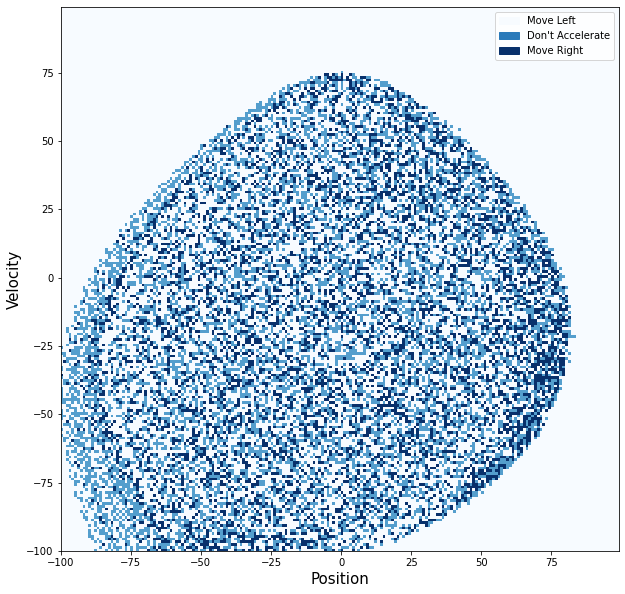

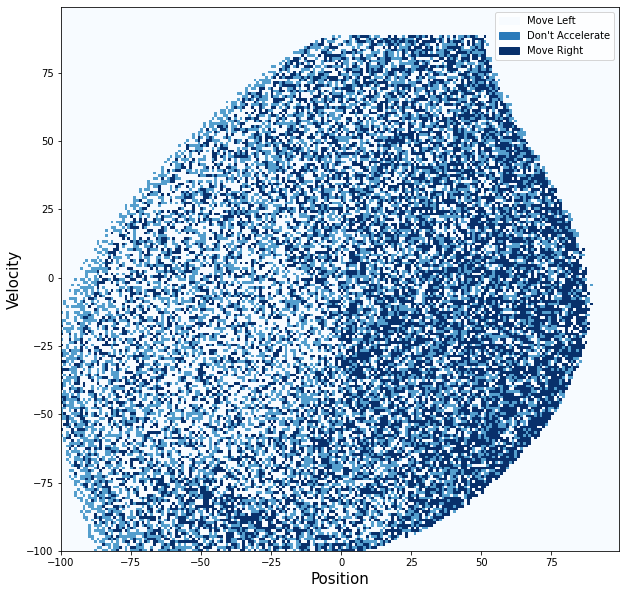

In [145]:
fig = plt.figure()

for i in [q_table_l[3], q_table_l[-1]]:
    mat_actions = np.argmax(i, axis =2)
    
    visualise_actions(mat_actions) #make gif of this
    plt.show

## Making Animations

In [91]:
# fig = plt.figure()
# camera = Camera(fig)
# ax = fig.add_subplot()

# for index, i in enumerate(q_table_l[::3]):
#     if index%100 == 0:
#         print(index, "/", len(q_table_l))
    
#     mat_actions = np.argmax(i, axis =2)
    
#     visualise_actions(mat_actions, ax) #make gif of this
    
#     plt.clf
#     camera.snap()
#     plt.show()

In [92]:
# animation = camera.animate(interval = 20, repeat = True, repeat_delay = 5000)

In [93]:
# animation.save('anim_ value_func_full.gif', writer='PillowWriter', fps=30)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


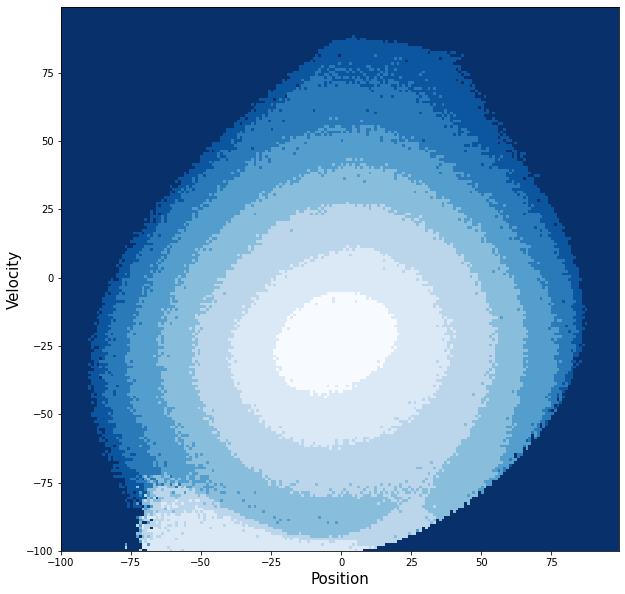

In [149]:
mat_actions = np.max(q_table_l[-1], axis =2)
    
visualise_conf(mat_actions)

# Gradient Descent Functions

In [7]:
q_table = q_table_l[-1]

NameError: name 'q_table_l' is not defined

In [8]:
q_table.shape

NameError: name 'q_table' is not defined

In [10]:
def construct_states(n = n_states):
    states = []
    for i in range(n):
        for j in range(n):
            for k in range(3):
#                 print(i, j, k)
                states.append(np.array([i, j,k]))
    states = np.asarray(states)
    return(states)

In [11]:
states = construct_states(n_states)

In [12]:
states

array([[ 0,  0,  0],
       [ 0,  0,  1],
       [ 0,  0,  2],
       ...,
       [39, 39,  0],
       [39, 39,  1],
       [39, 39,  2]])

In [13]:
def get_means(J):
    """
    Getting J cluster centers for the radial basis model
    """
#     print(df_values.shape)
    X = states #state space is the position, velocity and action
    means = []

    N = len(states)
    sig = np.std(X)
    
    for i in range(3):
        means.append(np.linspace(X[:, i].min(), X[:, i].max(), J))
    means  = np.array(means).T
    print(means.shape)
    U = np.zeros((N,J))

    for i in range(N):
        for j in range(J):
            U[i][j] = np.exp(-0.5 *np.linalg.norm(X[i] - means[j])/(sig))
    
    return(U, means)

In [14]:
U, kmeans = get_means(J)

(10, 3)


In [15]:
def evaluate_action(pos, vel, a, w):
    """
    Getting the value from a state
    
    input: state, action, weights vector
    
    Output: value of action in that state
    
    Method: convert the state and action into the design matrix, then dot product the weights 
    
    """
    states = np.array([pos, vel, a])
    U = []
    for j in range(J):
        U.append(np.exp(-0.5 *np.linalg.norm(states - kmeans[j])/sig))
    return(U @ w, U)

In [16]:
def evaluate_state(pos, vel, w):
    """
    RBF for the values of all possible actions from that state
    
    """
    vals = []
    for act in range(3):
        U = []
        states = np.array([pos, vel, act])
        for j in range(J):
            U.append(np.exp(-0.5 *np.linalg.norm(states - kmeans[j])/sig))
        vals.append(U @ w)
    return(vals)

In [17]:
X = states #state space is the position, velocity and action
sig = np.std(X)

# Online Learning Algorithms

In [18]:
def discretization_online(env, obs):
    env_low = env.observation_space.low
    env_high = env.observation_space.high
    env_den = (env_high - env_low)# / n_states
    pos_den = env_den[0]
    vel_den = env_den[1]
    pos_high = env_high[0]
    pos_low = env_low[0]
    vel_high = env_high[1]
    vel_low = env_low[1]
    pos_scaled =(obs[0] - pos_low) / pos_den   #int((obs[0] - pos_low) / pos_den)
    vel_scaled = (obs[1] - vel_low) / vel_den#int((obs[1] - vel_low) / vel_den)
    return(pos_scaled, vel_scaled)


In [19]:
def learn_online(mode = "q_learning", n_states = 40,
    episodes = 50,
    initial_lr = 1.0,
    min_lr = 0.005,
    gamma = 0.99,
    max_stps = 100000,
    epsilon = 0.05):
    
    env_name = "MountainCar-v0"
    env = gym.make(env_name)
    obs = env.reset()

    env = env.unwrapped
    env.seed()
    np.random.seed(0)
    
    steps_count = []


    w = np.random.rand(J, 1)
    
    
    for episode in range(episodes):
        
            
        # by solving bellmans equations for a number of episodes we can optain a value function of that policy at every state
        # we can improve the policy (what is the action im going to take given a state)

        obs = env.reset()

        alpha = max(min_lr, initial_lr*(gamma**(episode/0.1)))# max(min_lr, initial_lr*(gamma**(episode//100)))
        
        steps = 0
        while True:

            pos, vel = discretization_online(env, obs)

            if np.random.uniform(low=0, high=1) < epsilon:
                a = np.random.choice(env.action_space.n)
                a_value, U = evaluate_action(pos, vel, a, w)
            else:
                a = np.argmax(evaluate_state(pos, vel, w))
                a_value, U = evaluate_action(pos, vel, a, w)

            obs, reward, terminate,_ = env.step(a)
            pos_, vel_ = discretization_online(env, obs)

            if mode == "sarsa":
                if np.random.uniform(low=0, high=1) < epsilon:

                    next_val = np.random.choice(np.array(evaluate_state(pos_,vel_, w)).reshape(3))
                else:
                    next_val = np.max(evaluate_state(pos_,vel_, w)) 

            elif mode == "q_learning":
                next_val = np.max(evaluate_state(pos_,vel_, w))
            else:
                raise ValueError('Please choose either sarsa or q_learning')
            # Q function update

            w += (alpha * (reward + gamma*next_val - a_value) * U).reshape(J,1)


            steps += 1
            
            if steps%max_stps == 0:
                print("FAILED")
                break
            if terminate:
                steps_count.append(steps)
                print("Episode:", episode, "Steps: ", steps)
                break
    return(w, steps_count)

In [20]:
w_q_learning, q_learning_steps = learn_online("q_learning")

Episode: 0 Steps:  7253
Episode: 1 Steps:  25775
Episode: 2 Steps:  4946
Episode: 3 Steps:  22171
Episode: 4 Steps:  12201
Episode: 5 Steps:  2319
Episode: 6 Steps:  22442
Episode: 7 Steps:  22526
Episode: 8 Steps:  6980
Episode: 9 Steps:  1012
Episode: 10 Steps:  4759
Episode: 11 Steps:  678
Episode: 12 Steps:  2154
Episode: 13 Steps:  1207
Episode: 14 Steps:  899
Episode: 15 Steps:  4293
Episode: 16 Steps:  4644
Episode: 17 Steps:  4192
Episode: 18 Steps:  7087
Episode: 19 Steps:  2592
Episode: 20 Steps:  1059
Episode: 21 Steps:  3963
Episode: 22 Steps:  1641
Episode: 23 Steps:  144
Episode: 24 Steps:  688
Episode: 25 Steps:  1331
Episode: 26 Steps:  4031
Episode: 27 Steps:  1549
Episode: 28 Steps:  689
Episode: 29 Steps:  451
Episode: 30 Steps:  1201
Episode: 31 Steps:  1909
Episode: 32 Steps:  1288
Episode: 33 Steps:  1304
Episode: 34 Steps:  145
Episode: 35 Steps:  479
Episode: 36 Steps:  1005
Episode: 37 Steps:  147
Episode: 38 Steps:  1444
Episode: 39 Steps:  223
Episode: 40 Ste

In [36]:
w_sarsa, sarsa_steps = learn_online("sarsa")

Episode: 0 Steps:  8024
Episode: 1 Steps:  30317
Episode: 2 Steps:  30649
Episode: 3 Steps:  10576
Episode: 4 Steps:  22408
Episode: 5 Steps:  4366
Episode: 6 Steps:  1685
Episode: 7 Steps:  3100
Episode: 8 Steps:  2823
Episode: 9 Steps:  1211
Episode: 10 Steps:  3009
Episode: 11 Steps:  219
Episode: 12 Steps:  465
Episode: 13 Steps:  2370
Episode: 14 Steps:  302
Episode: 15 Steps:  711
Episode: 16 Steps:  828
Episode: 17 Steps:  319
Episode: 18 Steps:  863
Episode: 19 Steps:  864
Episode: 20 Steps:  1952
Episode: 21 Steps:  2206
Episode: 22 Steps:  2034
Episode: 23 Steps:  306
Episode: 24 Steps:  533
Episode: 25 Steps:  1115
Episode: 26 Steps:  927
Episode: 27 Steps:  385
Episode: 28 Steps:  789
Episode: 29 Steps:  776
Episode: 30 Steps:  760
Episode: 31 Steps:  1006
Episode: 32 Steps:  622
Episode: 33 Steps:  144
Episode: 34 Steps:  1226
Episode: 35 Steps:  1767
Episode: 36 Steps:  450
Episode: 37 Steps:  387
Episode: 38 Steps:  1359
Episode: 39 Steps:  141
Episode: 40 Steps:  527
Ep

In [37]:
w_sarsa

array([[  9.00272147],
       [-44.37805243],
       [-42.61967406],
       [-35.45304963],
       [-28.68595503],
       [-22.63618869],
       [-18.08550219],
       [-13.80180018],
       [-10.67109037],
       [ -8.81832143]])

In [21]:
def generate_table(w, n_states = n_states):
    table = np.zeros([n_states,n_states])
    step = 0
    for i in range(n_states):
        for j in range(n_states):

            table[i][j] = np.argmax(evaluate_state(i/n_states, j/n_states, w))
            step += 1
    return(table)

In [22]:
sarsa_tab = generate_table(w_sarsa)
q_learning_tab = generate_table(w_q_learning)

In [28]:
(sarsa_tab == 2).sum()

1572

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


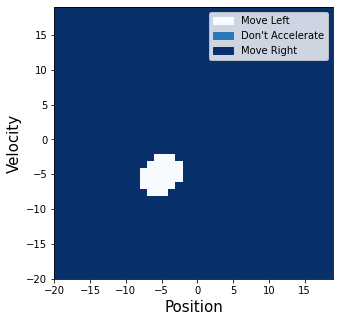

In [29]:
visualise_actions(sarsa_tab)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


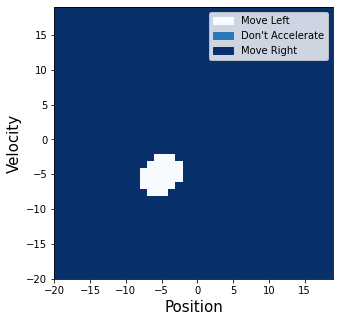

In [30]:
visualise_actions(q_learning_tab)

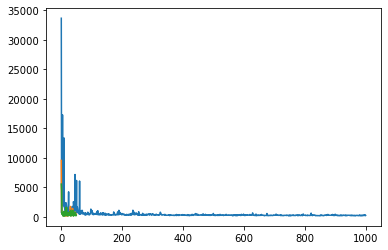

In [37]:
for i in [tabular_steps, q_learning_steps, sarsa_steps]:
    plt.plot(range(len(i)), i)

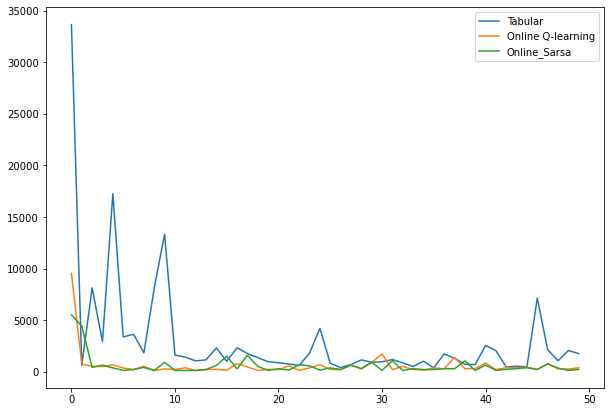

In [36]:
labels = ["Tabular", "Online Q-learning", "Online_Sarsa"]
plt.figure(figsize = (10, 7))
for index, i in enumerate([tabular_steps[:50], q_learning_steps, sarsa_steps]):
    plt.plot(range(len(i)), i, label = labels[index])
plt.legend()

## RUN Q_LEARNING

In [28]:
failed = 0
for e in range(100):
    obs = env.reset()
    steps = 0
    while True:
#         env.render()
        pos, vel = discretization_online(env, obs)

        a = np.argmax(evaluate_state(pos, vel, w_q_learning))

        obs, reward, terminate, _ = env.step(a)
        steps += 1

        if steps >= 2000:
            print("FAILED")
            failed += 1
            break
        if terminate:
            time.sleep(1)
            print(steps)
            break

144
FAILED
FAILED
FAILED
144
144
148
FAILED
FAILED
FAILED
FAILED
144
FAILED
143
FAILED
FAILED
FAILED
FAILED
FAILED
144
151
145
143
143
155
145
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
151
145
FAILED
FAILED
145
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
151
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
155
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
143
FAILED
FAILED
151
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
144
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED
FAILED


In [29]:
(100-failed)/100

0.21

## RUN SARSA

In [38]:
epsilon = 0.05

In [40]:
failed_s = 0
for e in range(100):
    obs = env.reset()
    steps = 0
    while True:
        # env.render()
        pos, vel = discretization_online(env, obs)

        if np.random.uniform(low=0, high=1) < epsilon:
            a = np.random.choice(env.action_space.n)
   
        else:
             a = np.argmax(evaluate_state(pos, vel, w_sarsa))
        obs, reward, terminate, _ = env.step(a)
        steps += 1

        if steps >=2000:
            print("FAILED")
            failed_s += 1
            break
        if terminate:
            time.sleep(1)
            print(steps)
            break

1387
FAILED
151
151
FAILED
224
139
FAILED
142
FAILED
307
140
1114
819
145
756
142
1171
FAILED
1679
314
1004
FAILED
615
1033
162
FAILED
FAILED
142
143
142
FAILED
FAILED
144
1052
150
155
1546
1275
482
1515
459
FAILED
FAILED
149
147
520
FAILED
260
400
FAILED
FAILED
141
146
412
FAILED
FAILED
1298
249
145
1254
222
377
144
FAILED
1315
145
258
673
677
FAILED
153
149
693
FAILED
144
1145
735
143
141
FAILED
233
730
163
146
611
1535
1133
140
144
1828
144
137
1157
FAILED
1857
427
996
149
149


In [41]:
100-failed_s

78

Text(0, 0.5, 'Trained Model Success Rate (%)')

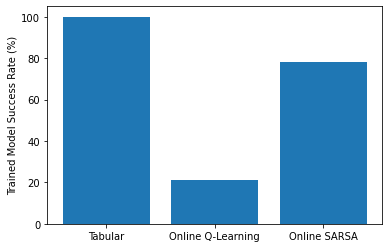

In [49]:
plt.bar(["Tabular", "Online Q-Learning", "Online SARSA"], [100, 21, 78])
plt.ylabel("Trained Model Success Rate (%)")